In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Embedding,Dropout,TimeDistributed,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import numpy as np

%matplotlib inline

In [8]:
df = pd.read_csv('./regression_data/time_series.csv',delimiter='\t')
df.head()

,1,2,3,4,5
0,-0.979234,-1.416973,-0.489459,-1.729622,-0.134724
1,-1.299158,-1.113212,-0.632251,-1.737313,-0.248217
2,-1.376446,-1.950953,-1.086232,-0.829957,-0.726847
3,-1.411108,-2.811393,-1.302569,-1.132002,0.212635
4,-1.609624,-2.773193,-0.696774,-1.382566,-0.250348


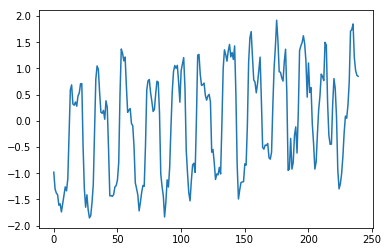

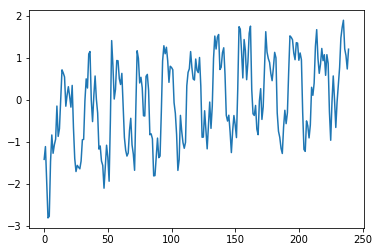

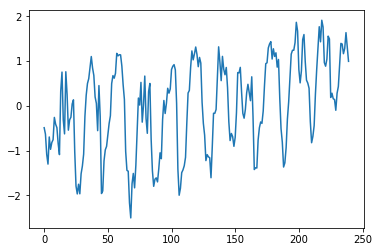

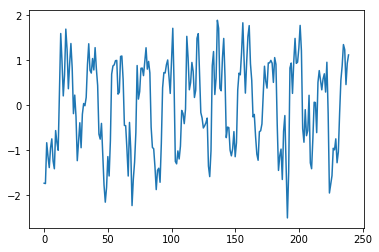

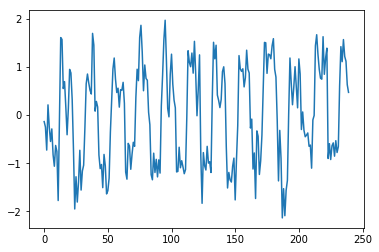

In [9]:
for i in df.columns:
    df[i].plot()
    plt.show()

In [10]:
mms = MinMaxScaler(feature_range=(-1, 1))
data = mms.fit_transform(df)

In [11]:
def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
        
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[:-1, :]
    
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [13]:
lag = 20
train_X = np.array([]).reshape(0,lag)
train_y = np.array([])
one_line_data = np.array([])
for i in range(data.shape[1]-1):
    X, y = create_data(data[:,i],lag)
    train_X = np.concatenate((X,train_X),axis=0)
    train_y = np.concatenate((y,train_y),axis=0)
    one_line_data = np.concatenate((one_line_data,data[:,i]),axis=0)
    
test_X, test_Y = create_data(data[:,-1],lag)
one_line_data = np.concatenate((one_line_data,data[:,-1]),axis=0)

one_line_data = one_line_data.reshape(-1,1)

In [14]:
# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [15]:
np.random.seed(42)

batch_size = 1
model = Sequential()
# model.add(LSTM(2, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True, return_sequences=True))
model.add(LSTM(4, 
               batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), 
               stateful=True))
model.add(Dense(1))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='mean_squared_error', optimizer='adam')
number_of_steps = 30
for i in range(number_of_steps):
    print('Step '+str(i+1)+'/'+str(number_of_steps))
    model.fit(train_X, train_y, validation_data=(test_X, test_Y), 
              epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Step 1/30
Train on 880 samples, validate on 220 samples
Epoch 1/1
880/880 [==============================] - 7s 8ms/step - loss: 0.1315 - val_loss: 0.0950
Step 2/30
Train on 880 samples, validate on 220 samples
Epoch 1/1
880/880 [==============================] - 6s 7ms/step - loss: 0.0729 - val_loss: 0.0820
Step 3/30
Train on 880 samples, validate on 220 samples
Epoch 1/1
880/880 [==============================] - 6s 7ms/step - loss: 0.0660 - val_loss: 0.0809
Step 4/30
Train on 880 samples, validate on 220 samples
Epoch 1/1
880/880 [==============================] - 8s 9ms/step - loss: 0.0637 - val_loss: 0.0808
Step 5/30
Train on 880 samples, validate on 220 samples
Epoch 1/1
880/880 [==============================] - 6s 7ms/step - loss: 0.0626 - val_loss: 0.0810
Step 6/30
Train on 880 samples, validate on 220 samples
Epoch 1/1
880/880 [==============================] - 7s 7ms/step - loss: 0.0619 - val_loss: 0.0810
Step 7/30
Train on 880 samples, validate on 220 samples
Epoch 1/1
880/

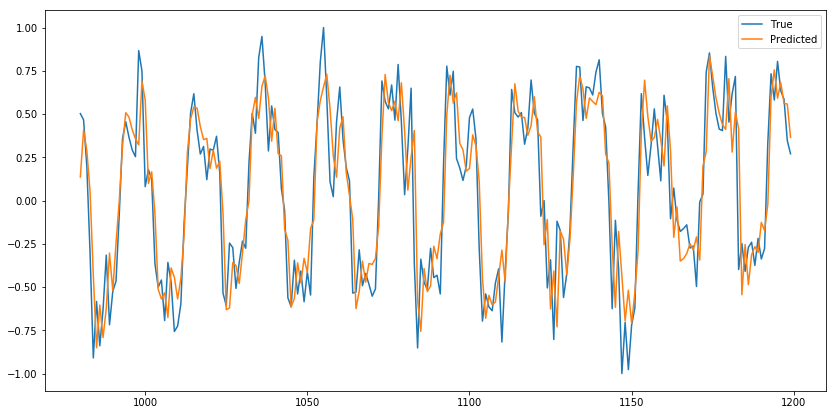

In [17]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

train_predict = model.predict(train_X, batch_size=batch_size)
test_predict = model.predict(test_X, batch_size=batch_size)
test_observed = one_line_data[-len(test_predict):, :]

# print('MAE = ', mean_absolute_error(test_observed, test_predict))
# print('MSE = ', mean_squared_error(test_observed, test_predict))

# shift train predictions for plotting
train_predict_plot = np.empty_like(one_line_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lag:len(train_predict)+lag, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot = np.empty_like(one_line_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[-len(test_predict):, :] = test_predict

# shift true values for plotting with test data only
test_true_plot = np.empty_like(one_line_data)
test_true_plot[:, :] = np.nan
test_true_plot[-len(test_predict):, :] = one_line_data[-len(test_predict):,:]
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
# plt.plot(one_line_data)
# plt.plot(train_predict_plot)
plt.plot(test_true_plot,label='True')
plt.plot(test_predict_plot,label='Predicted')
plt.legend()
plt.show()